In [1]:
import pandas as pd
names = [
    'bilancino',
    'arno',
    'auser',
    'doganella',
    'luco',
    'petrignano',
    'amiata',
    'lupa',
    'madonna_di_canneto'
]

kinds = [
    'lake',
    'river',
    'aquifer',
    'aquifer',
    'aquifer',
    'aquifer',
    'waterspring',
    'waterspring',
    'waterspring'
]
dfs = {n:pd.read_csv(f"../data/raw/{k}/{n}.csv") for k,n in zip(kinds, names)}

In [2]:
targets = {
    'auser': [
        'Depth_to_Groundwater_SAL',
        'Depth_to_Groundwater_CoS',
        'Depth_to_Groundwater_LT2'
    ],
    'doganella': [
        'Depth_to_Groundwater_Pozzo_1',
        'Depth_to_Groundwater_Pozzo_2',
        'Depth_to_Groundwater_Pozzo_3',
        'Depth_to_Groundwater_Pozzo_4',
        'Depth_to_Groundwater_Pozzo_5',
        'Depth_to_Groundwater_Pozzo_6',
        'Depth_to_Groundwater_Pozzo_7',
        'Depth_to_Groundwater_Pozzo_8',
        'Depth_to_Groundwater_Pozzo_9'
    ],
    'luco': ['Depth_to_Groundwater_Podere_Casetta'],
    'petrignano': [
        'Depth_to_Groundwater_P24',
        'Depth_to_Groundwater_P25'
    ],
    'amiata': [
        'Flow_Rate_Bugnano',
        'Flow_Rate_Arbure',
        'Flow_Rate_Ermicciolo',
        'Flow_Rate_Galleria_Alta'
    ],
    'lupa': ['Flow_Rate_Lupa'],
    'madonna_di_canneto': ['Flow_Rate_Madonna_di_Canneto'],
    'bilancino': ['Lake_Level', 'Flow_Rate'],
    'arno': ['Hydrometry_Nave_di_Rosano']
}

In [3]:
features = dict()
for k in dfs:
    cols = dfs[k].columns
    bad = set(targets[k]) | set(['Date'])
    features[k] = sorted(list(set(cols) - bad))

In [4]:
measurements = [
    'Depth_to_Groundwater',
    'Flow_Rate',
    'Hydrometry',
    'Lake_Level',
    'Rainfall',
    'Temperature',
    'Volume'
]

In [5]:
def parse_column(col):
    for m in measurements:
        if col.startswith(m):
            loc = col[len(m):]
            loc = loc[1:] if len(loc) > 0 else ''
            return [m, loc]

In [6]:
columns = {n: dict(features=features[n],targets=targets[n]) for n in names}

In [7]:
predf = dict(
    Location=[],
    Measurement=[],
    Waterbody=[],
    Feature=[],
    Target=[]
)

for wb in columns:
    for col in columns[wb]['features']:
        m, loc = parse_column(col)
        predf['Location'].append(loc)
        predf['Measurement'].append(m)
        predf['Waterbody'].append(wb)
        predf['Feature'].append(1)
        predf['Target'].append(0)
    for col in columns[wb]['targets']:
        m, loc = parse_column(col)
        if loc == '':
            loc = float('nan')
        predf['Location'].append(loc)
        predf['Measurement'].append(m)
        predf['Waterbody'].append(wb)
        predf['Feature'].append(0)
        predf['Target'].append(1)

df = pd.DataFrame(predf)

In [8]:
# searching stazioni.csv for geo-data was already performed in `better_geo_lookup.ipynb`
import json
stazioni = pd.read_csv('../data/geo/stazioni.csv', ';')
with open('../data/geo/station-search.json', 'r') as fp:
    searches = json.load(fp)

In [9]:
def find_loc_in_searches(loc):
    for q in searches:
        if q['location'] == loc:
            return q
def find_row_in_stazioni(idx):
    return stazioni.loc[idx]

In [10]:
# construct the full columns before adding it to the dataframe
sid = []
lat = []
lon = []
ele = []

for loc in df['Location'].values:
    if loc != loc: # bilancino's targets have no location specified
        sid.append(float('nan'))
        lat.append(float('nan'))
        lon.append(float('nan'))
        ele.append(float('nan'))
    else:
        q = find_loc_in_searches(loc)
        if 'final' in q:
            r = find_row_in_stazioni(q['final'])
            sid.append(r['IDStazione'])
            lat.append(r['LAT [o]'])
            lon.append(r['LON [o]'])
            ele.append(r['Quota'])
        else:
            sid.append(float('nan'))
            lat.append(float('nan'))
            lon.append(float('nan'))
            ele.append(float('nan'))

df['StationID'] = sid
df['Latitude'] = lat
df['Longitude'] = lon
df['Elevation'] = ele

In [11]:
# we now have a single dataset containing:
#
# - each location mentioned
# - measurements taken at each location
# - geodata (where we could find it) of each location
# - which dataset a location/measurement belongs to
# - whether it's a feature or a target
#
# not bad for 2 weeks past the due date 😏

df.to_csv('../data/meta/overview.csv', index=False)

# Conglomerated Table

## Step 0: Is our data truly day-by-day?

In [71]:
for wb in dfs:
    print(wb, dfs[wb]['Date'].isnull().sum())

auser 0
doganella 0
luco 0
petrignano 0
amiata 0
lupa 0
madonna_di_canneto 9
bilancino 0
arno 0


In [72]:
dfs['madonna_di_canneto'][dfs['madonna_di_canneto']['Date'].isnull()]

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
3104,NaN,NaN,NaN,NaN
3105,NaN,NaN,NaN,NaN
3106,NaN,NaN,NaN,NaN
3107,NaN,NaN,NaN,NaN
3108,NaN,NaN,NaN,NaN
3109,NaN,NaN,NaN,NaN
3110,NaN,NaN,NaN,NaN
3111,NaN,NaN,NaN,NaN
3112,NaN,NaN,NaN,NaN


In [73]:
dfs['madonna_di_canneto'].index[-1]

3112

The last 9 rows of `Madonna_di_Canneto` are null; we can just drop them

In [7]:
tmp = dfs['madonna_di_canneto']
dfs['madonna_di_canneto'] = tmp[~tmp['Date'].isnull()]

In [12]:
# all datasets have no missing dates;
# confirm that each row is one day after the last
for wb in dfs:
    dd = pd.to_datetime(dfs[wb]['Date'], format='%d/%m/%Y')
    last = None
    for d in dd:
        if last is not None:
            assert last + pd.Timedelta('1d') == d

## Step 1: Does equal column name imply equal data?

In [57]:
# which location/measurement pairs show up in different datasets?
_df = df.groupby(['Location', 'Measurement'], as_index=False)['Waterbody'].count()
_df = _df[_df['Waterbody'] > 1]
dupes = sorted(f"{row.Measurement}_{row.Location}" for row in _df.itertuples())
dupes

['Depth_to_Groundwater_Pozzo_1',
 'Depth_to_Groundwater_Pozzo_3',
 'Depth_to_Groundwater_Pozzo_4',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_S_Piero',
 'Volume_Pozzo_1',
 'Volume_Pozzo_3',
 'Volume_Pozzo_4']

In [60]:
# which datasets do they show up in?
dupes = {c:[] for c in dupes}
for c in dupes:
    for wb in dfs:
        if c in dfs[wb].columns:
            dupes[c].append(wb)
pd.DataFrame(dupes).T

,0,1
Depth_to_Groundwater_Pozzo_1,doganella,luco
Depth_to_Groundwater_Pozzo_3,doganella,luco
Depth_to_Groundwater_Pozzo_4,doganella,luco
Rainfall_Cavallina,bilancino,arno
Rainfall_Le_Croci,bilancino,arno
Rainfall_Mangona,bilancino,arno
Rainfall_S_Agata,bilancino,arno
Rainfall_S_Piero,bilancino,arno
Volume_Pozzo_1,doganella,luco
Volume_Pozzo_3,doganella,luco


In [65]:
# do they always have the same values?

# (but first, some helper functions; please ignore, just skip ahead)
def get(c):
    return (
        dfs[dupes[col][0]][col].values.tolist(),
        dfs[dupes[col][1]][col].values.tolist()
    )
def norm(a, b):
    shouldhave = max(len(a), len(b))
    a_is_major = len(a) == shouldhave
    major = a if a_is_major else b
    minor = b if a_is_major else a
    while len(minor) < shouldhave:
        minor = [float('nan')] + minor
    return (major,minor) if a_is_major else (minor,major)
def all_equal(a, b):
    for i in range(len(a)):
        both_null = a[i] != a[i] and b[i] != b[i]
        both_eq = both_null or a[i] == b[i]
        if not both_eq:
            return False
    return True

# (ahem) do they always have the same values?
for col in dupes:
    a, b = get(col)
    a, b = norm(a, b) # diff. datasets have diff. lengths
    if not all_equal(a, b):
        print(col)

Depth_to_Groundwater_Pozzo_1
Depth_to_Groundwater_Pozzo_3
Depth_to_Groundwater_Pozzo_4
Volume_Pozzo_1
Volume_Pozzo_3
Volume_Pozzo_4


In [10]:
# sometimes no :(
didntwork = [
    'Depth_to_Groundwater_Pozzo_1',
    'Depth_to_Groundwater_Pozzo_3',
    'Depth_to_Groundwater_Pozzo_4',
    'Volume_Pozzo_1',
    'Volume_Pozzo_3',
    'Volume_Pozzo_4'
]

In [16]:
import matplotlib.pyplot as plt

In [68]:
# plot the columns from different datasets against each other
def cf(col):
    a = dfs['doganella']
    b = dfs['luco']
    ad = pd.to_datetime(a['Date'], format='%d/%m/%Y')
    bd = pd.to_datetime(b['Date'], format='%d/%m/%Y')
    plt.figure(figsize=(20,5))
    plt.plot(ad, a[col])
    plt.plot(bd, b[col])
    plt.title(col)
    plt.show()

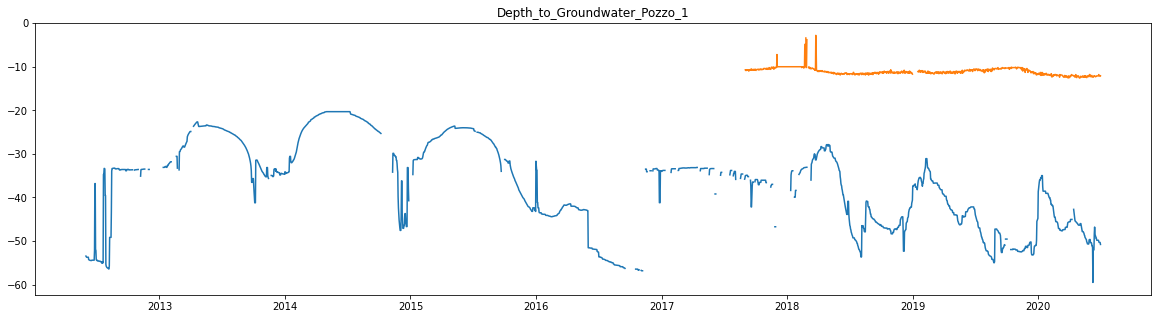

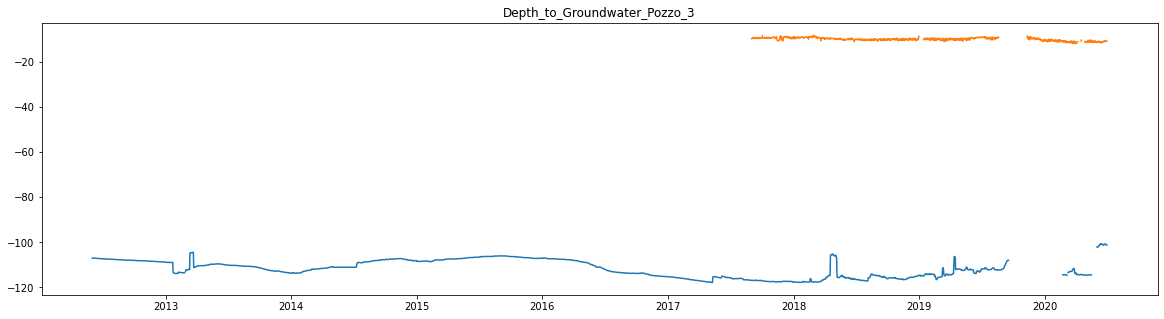

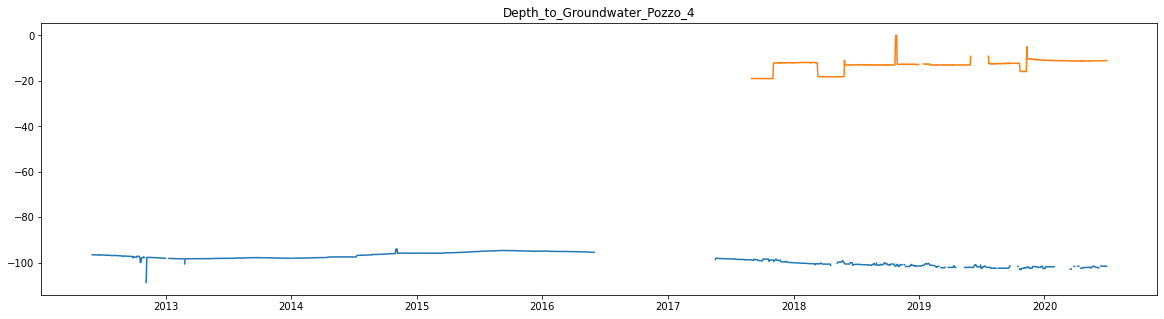

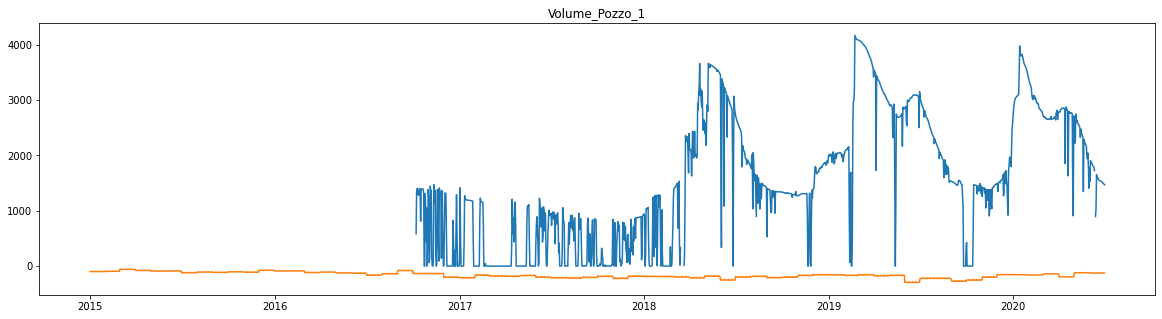

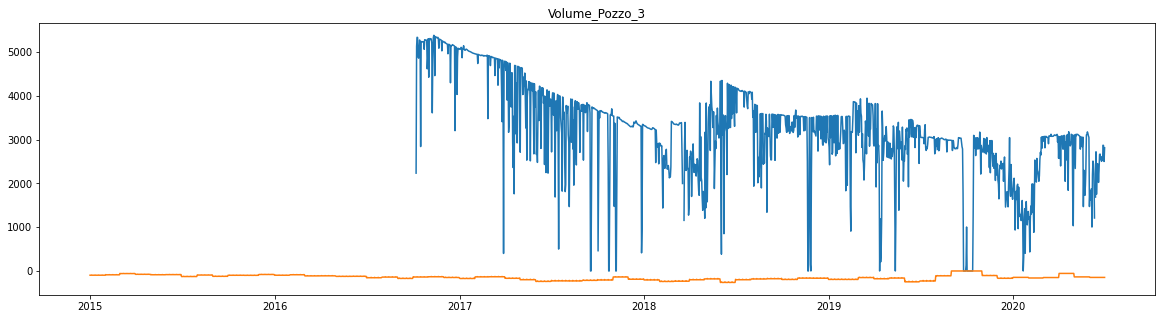

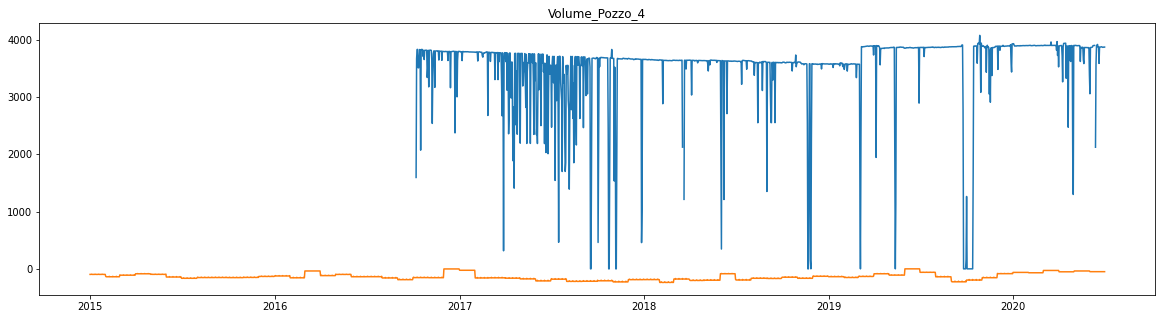

In [69]:
for col in didntwork:
    cf(col)

Despite the similar names, these columns will need to be treated as different data when compiling everything into a master table (eg, prefixed with table name).

## Step 2: Compilation

In [8]:
# arno is the oldest, starting on 1/1/98
# (all datasets end on 6/30/20)
conglom = dfs['arno'].copy()

In [11]:
for wb in dfs:
    if wb == 'arno':
        
        # this is so friggin stupid:
        # we start with arno so that we never
        # have to worry about conglom not having
        # enough rows for the dates
        # --but I want bilancino to come before
        # arno, in the plot--so we'll
        # make sure bilancino is first,
        # arno is second; but because *conglom*
        # started from arno, we will now
        # drop those columns and re-add arno
        #    --my deepest apologies
        bilans = dfs['bilancino'].columns
        conglom = conglom[bilans]
    
    # sort so the targets are at the "end"
    df = dfs[wb][['Date'] + columns[wb]['features'] + columns[wb]['targets']]
    
    # how many NaN's do we have to prepend to each column?
    n = conglom.shape[0] - df.shape[0]
    
    for c in df.columns:
        if c == 'Date':
            continue
        
        # is this a column where we need to specify the source table?
        c2 = f"{c}_{wb.capitalize()}" if c in didntwork else c
        
        # is this a column we've already added?
        # if c2 in conglom.columns:
        #     continue
        # lol this turns out to be an unnecessary check
        
        buffer = [float('nan')] * n
        vals = df[c].values.tolist()
        conglom[c2] = buffer + vals

In [109]:
conglom.to_csv('../data/raw/conglomerated.csv', index=False)

In [29]:
pd.to_datetime(conglom['Date'], format='%d/%m/%Y')[0].day_of_year

1

In [12]:
import numpy as np

In [18]:
all_targets = []
for wb in targets:
    for col in targets[wb]:
        c2 = f"{col}_{wb.capitalize()}" if col in didntwork else col
        all_targets.append(c2)
istar = conglom.columns.isin(all_targets)
istar_idx = []
for i,v in enumerate(istar):
    if v:
        istar_idx.append(i)
from matplotlib import gridspec
def missplot(df):
    z = df.notnull().values.astype(int)
    for i in istar_idx:
        z[:,i] *= 2
    g = np.zeros((df.shape[0], df.shape[1], 3), dtype=np.float32)
    g[z == 0] = [1,1,1]
    g[z == 1] = (0.25, 0.25, 0.25)
    g[z >= 2] = (0.75, 0.25, 0.25)
    plt.figure(figsize=(100,100))
    gs = gridspec.GridSpec(1,1)
    ax0 = plt.subplot(gs[0])
    ax0.imshow(g, interpolation='none')
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.set_xticks(list(range(0, df.shape[1])))
    ax0.set_xticklabels(list(df.columns), rotation=45, ha='left', fontsize=12)
    dd = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    ys = [dd[int(idx)].strftime('%m/%d/%y') if idx in dd.index else idx for idx in ax0.get_yticks()]
    ax0.set_yticklabels(ys)
    btw = [x + 0.5 for x in range(0, df.shape[1] - 1)]
    for pt in btw:
        ax0.axvline(pt, linestyle='-', color='white')
    plt.gca().invert_yaxis()
    plt.suptitle('Missing Values Across All Datasets', fontsize=50, fontweight='bold', y=0.97)
    plt.title('Top is present, bottom is past; far left is date, red is target for all preceding black columns, white is missing data', fontsize=32)
    plt.show()

<ipython-input-18-68aca6183588>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(ys)


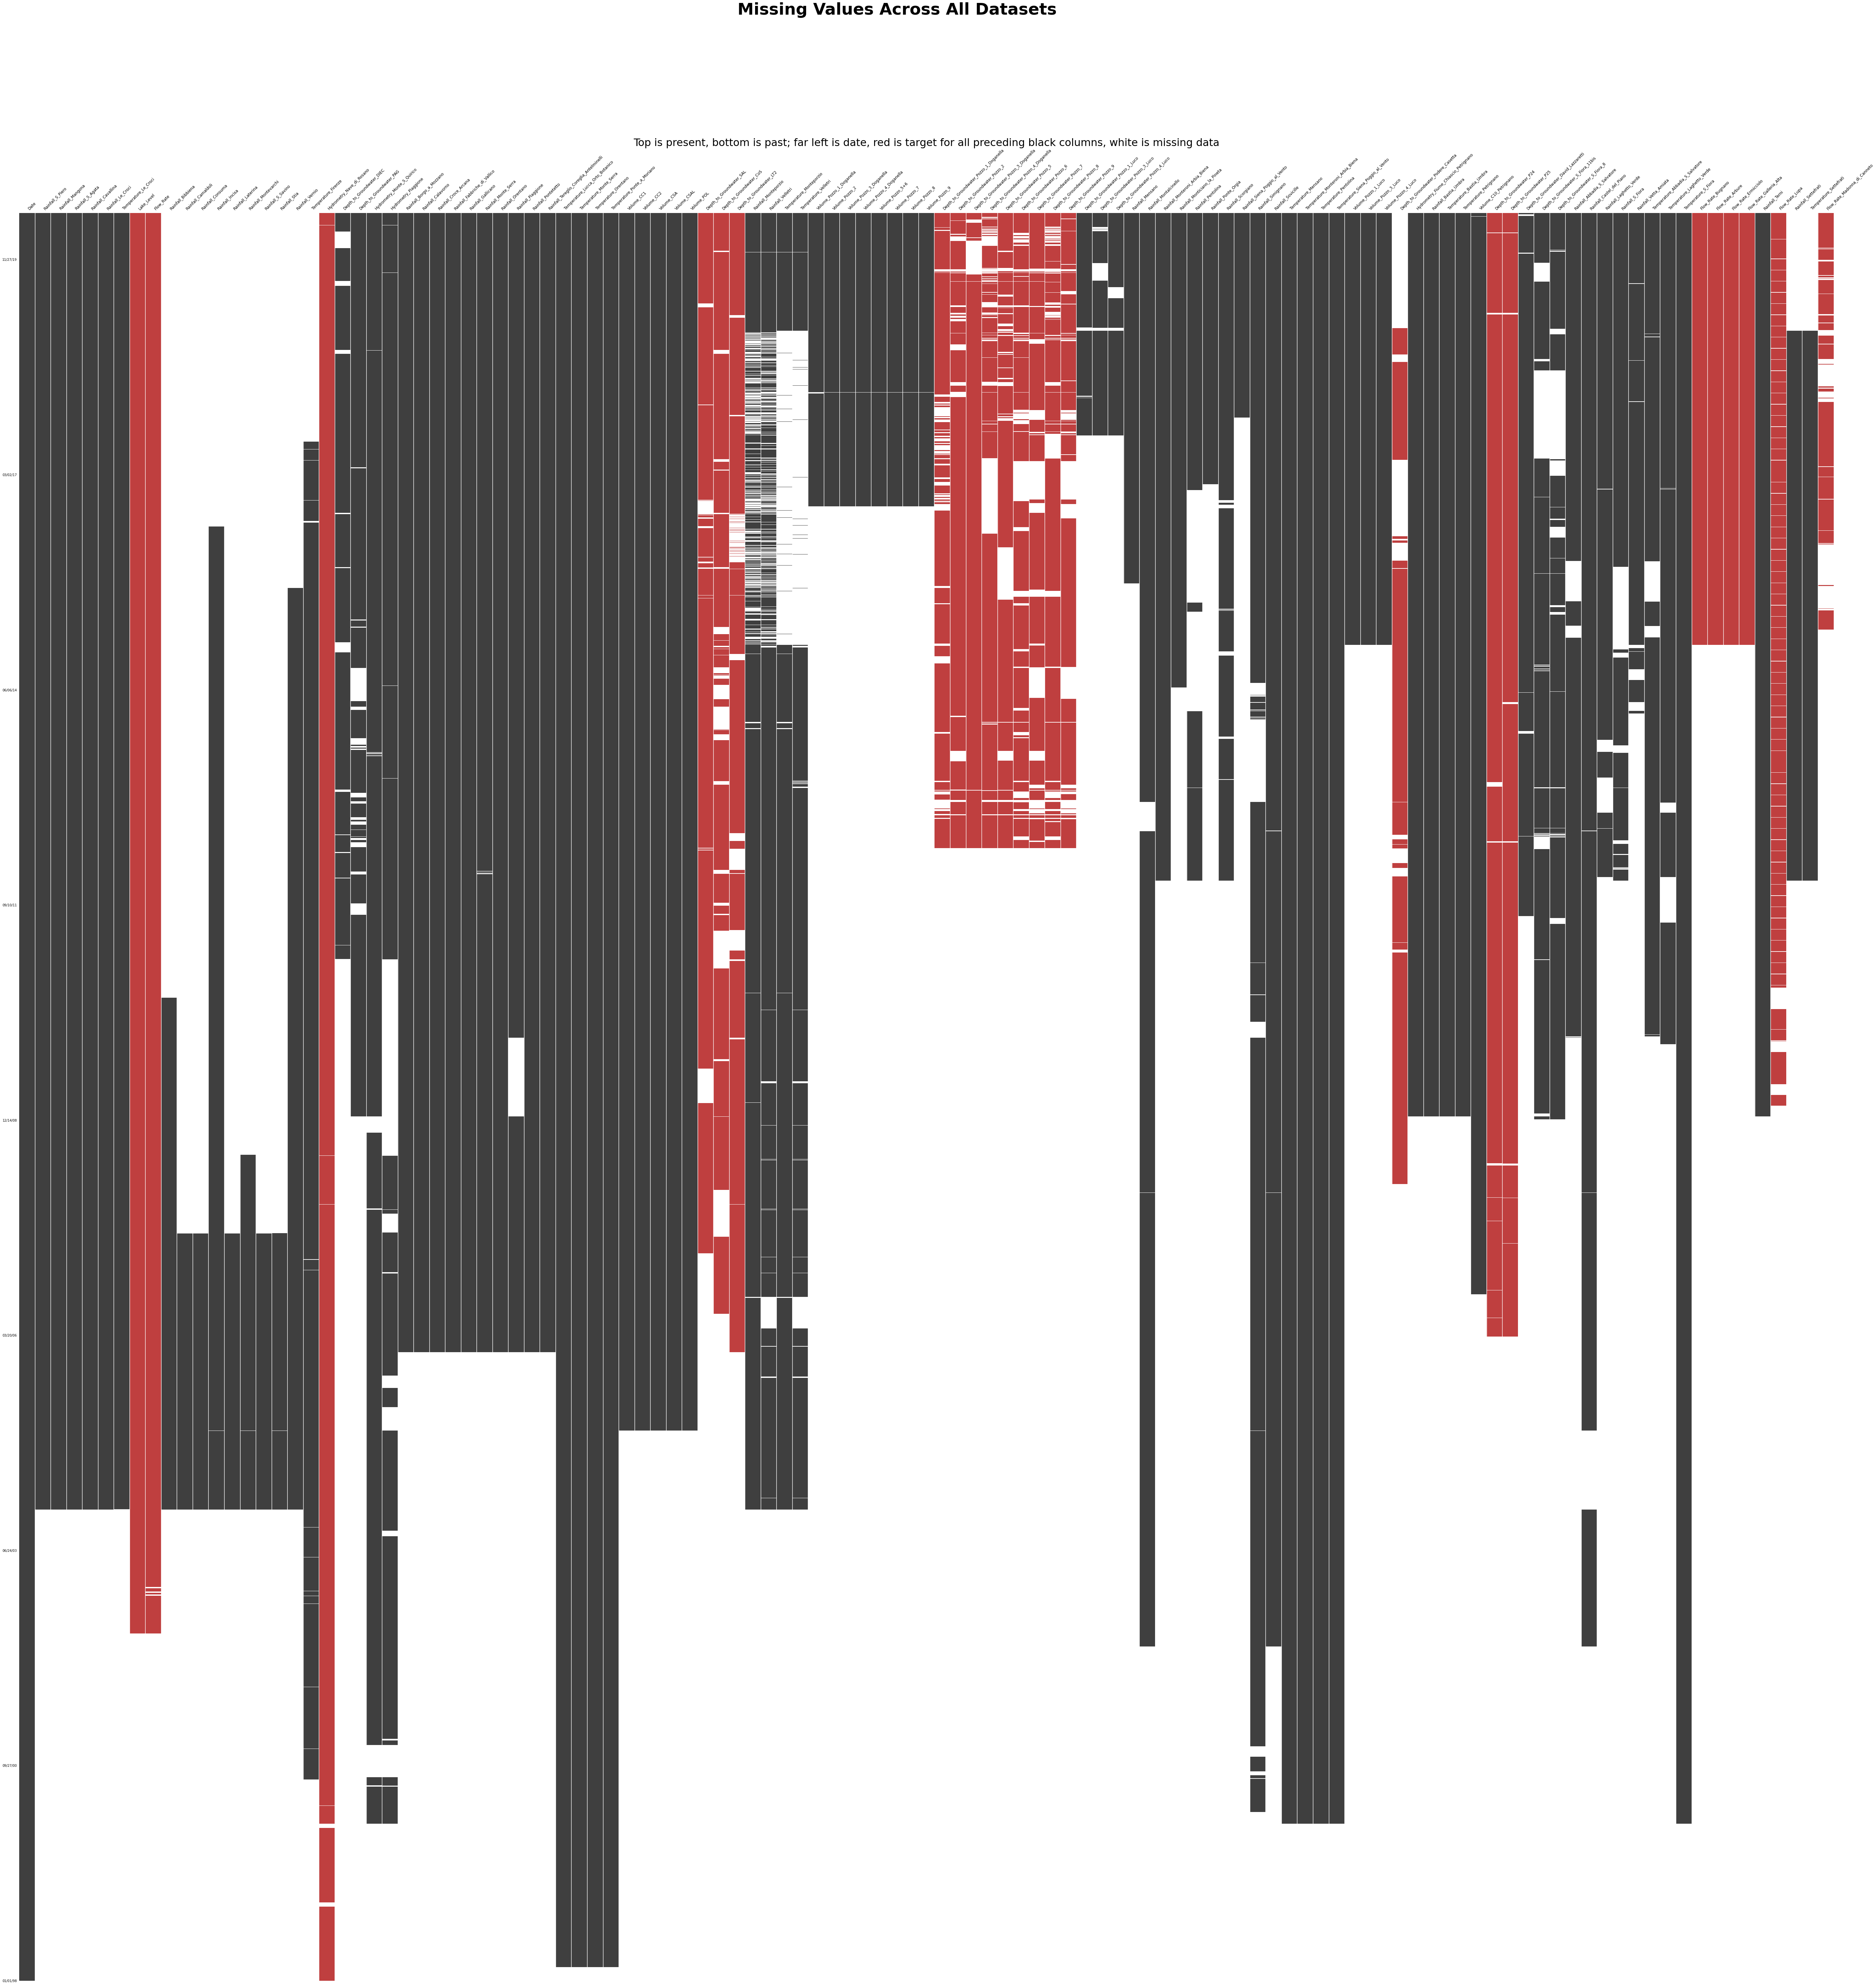

In [19]:
missplot(conglom)